In [1]:
import numpy as np
import astropy.units as u
import sbpy.activity as sba
import matplotlib.pyplot as plt
from sbpy.data import Phys
from astropy.visualization import quantity_support
from sbpy.activity.gas.core import VMResult

# Applying the vectorial model included in sbpy.activity

The vectorial model implemented here is described in [Festou 1981](https://ui.adsabs.harvard.edu/abs/1981A%26A....95...69F) and incorporated as a derived class of GasComa in [`sbpy.activity.gas`]() that serves as an alternative to the Haser model ([Haser 1957](https://ui.adsabs.harvard.edu/abs/1957BSRSL..43..740H/abstract), [Haser 2020](https://iopscience.iop.org/article/10.3847/PSJ/abc17b/meta)) to obtain the density distribution of neutral fragments produced by the photodissociation of parent molecules.

# Input parameters

### Parent and fragment data
The model supports two methods of specifying the parent production and its time dependence, both of which are covered below.  The observation time of the model is always at t = 0, and positive time values indicate farther into the past.

We begin by specifying some physical details about our parent and fragment molecules.
In our example calculations, the parent and fragment molecules are H2O and OH respectively:

In [2]:
# Rough parameters for a quick example calculation

# Parent molecule is H2O
parent_species = Phys.from_dict({
    # Total lifetime: will be smaller due to other sources of destruction, but this multiplicative
    # factor is approximate
    'tau_T': sba.photo_timescale('H2O') * 0.8,
    # Dissociative lifetime
    'tau_d': sba.photo_timescale('H2O'),
    # Outflow velocity, taken from Cochran and Schleicher, 1993
    'v_outflow': 0.85 * u.km/u.s,
    # Approximate cross section
    'sigma': 3e-16 * u.cm**2
    })

# Fragment is OH
fragment_species = Phys.from_dict({
    # Total lifetime: Again, factor of 0.8 is approximate
    'tau_T': sba.photo_timescale('OH') * 0.8,
    # Velocity after dissociation, taken from Cochran and Schleicher, 1993
    'v_photo': 1.05 * u.km/u.s
    })

print(parent_species)
print(fragment_species)

<QTable length=1>
 tau_T   tau_d  v_outflow  sigma 
   s       s      km / s    cm2  
float64 float64  float64  float64
------- ------- --------- -------
41600.0 52000.0      0.85   3e-16
<QTable length=1>
 tau_T   v_photo
   s      km / s
float64  float64
-------- -------
128000.0    1.05


### Time Dependence and Production: Method 1, binned production
The first method allows for an array of steady production values, paired with the times at which they start:

In [3]:
# 30 days ago to 5 days ago, Q was 1e28
# 5 days ago to 3 days ago, Q jumps to 5e28
# 3 days ago until present, Q was 2e28
times_at_production = [30, 5, 3] * u.day
production_rates = [1.e28, 5.e28, 2.e28] * (1/u.s)

# Line below is commented out because we don't need the notebook to actually run this calculation
# coma_one = sba.VectorialModel.binned_production(qs=production_rates, parent=parent_species, fragment=fragment_species, ts=times_at_production)

Note that the first entry in the production, 1e28, will be used by the model as a base production rate, which decides things like grid size, and extends that production backward to all times further in the past.

---

### Time Dependence and Production: Method 2, arbitrary time dependence
The second method allows the specification of a constant base_q production rate and an optional time-dependent production rate q_t that is additive to the base, so that the production at any time is

    q_tot = base_q + q_t(t)

If no q_t is given, then production is assumed to be steady at base_q.

Here we construct a water production that varies sinusoidally between 1e28 and 3e28 with a period of 10 hours:

In [11]:
def make_sine_q_t(amplitude, period, delta):
    period_in_secs = period.to(u.s).value
    delta_in_secs = delta.to(u.s).value
    amp_in_invsecs = amplitude.to(1/u.s).value
    const_B = (2.0 * np.pi)/period_in_secs

    def q_t(t):
        return amp_in_invsecs * (
                np.sin(const_B*(t + delta_in_secs)) + 1
                )

    return q_t

base_q = 1e28
q_t = make_sine_q_t(1e28 * (1/u.s), 10.0 * u.hour, -2.5 * u.hour)

# Check that this is actually doing what we want
for hour in [0, 2.5, 5.0, 7.5, 10.0]*u.hour:
    print(f"Production at t = {hour} ago:\t{base_q + q_t(hour.to(u.s).value):3.2e}")

Production at t = 0.0 h ago:	1.00e+28
Production at t = 2.5 h ago:	2.00e+28
Production at t = 5.0 h ago:	3.00e+28
Production at t = 7.5 h ago:	2.00e+28
Production at t = 10.0 h ago:	1.00e+28


And we hand this off to the model:

In [12]:
coma_sine = sba.VectorialModel(base_q=base_q*(1/u.s),
                          parent=parent_species,
                          fragment=fragment_species,
                          q_t=q_t,
                          print_progress=True
                          )

/Users/selfreference/repos/my_sbpy_fork/sbpy/activity/gas/core.py:974: TestingNeeded: Literature tests with the Vectorial model are generally in agreement at the 20% level or better.  The cause for the differences with the Festou FORTRAN code are not yet precisely known.  Help testing this feature is appreciated.
  warnings.warn(


Performing setup calculations...
Starting fragment density computations...
Interpolating radial fragment density...
Computing column densities...
Vectorial model calculations complete!


# Examining the results
After the calculations are finished, the results are stored in a VMResult dataclass that holds the volume and column densities, the grids used for both, interpolations of both, and some other quantities to help gauge the quality of the calculation.  It is accessible as the class variable 'vmr':

In [13]:
vmr = coma_sine.vmr

## VMResult dataclass overview
### vmr.volume_density_grid, vmr.column_density_grid
Numpy arrays of the radial points around the nucleus that were used in the fragment density calculations
### vmr.volume_density, vmr.column_density
Numpy arrays of volume and column density at the respective grid points given above, with astropy units attached
### vmr.fragment_sputter, vmr.solid_angle_sputter
Two-dimensional information detailing how fragments are ejected from a single column of outflowing parents
### vmr.volume_density_interpolation, vmr.column_density_interpolation
Interpolations of the volume and column density dervide from the gridded values.  The volume density is given in units of 1/m^3, and column density in units of 1/m^2.
### vmr.collision_sphere_radius
Estimate of where the outflowing parents transition from collisional to non-collisional
### vmr.max_grid_radius
How far from the nucleus the grid reaches.  Beyond this value the interpolators above will give an answer, but typically not a useful one.
### vmr.coma_radius
Defines the radius beyond which the model considers there to be no more parents
### vmr.num_fragments_theory
Theoretical count of the total number of fragments we expect - most accurate when there is no time-dependent production
### vmr.num_fragments_grid
Count produced by integrating the volume density over the volume of the entire grid
### vmr.t_perm_flow
Time necessary to reach the permanent flow regime, where production of parents is exactly balanced by parent loss due to photodissociation

## Fragment volume density

If we need to see the number density of the fragments as computed on the model's grid, we can see that here:

In [14]:
print("\n\nRadius (km) vs Fragment density (1/cm3)\n---------------------------------------")
for r, n_r in zip(vmr.volume_density_grid, vmr.volume_density):
    print(f'{r.to(u.km):7.0f} :\t{n_r.to(1/(u.cm**3)):5.3e}')



Radius (km) vs Fragment density (1/cm3)
---------------------------------------
    176 km :	1.553e+05 1 / cm3
    210 km :	1.310e+05 1 / cm3
    250 km :	1.106e+05 1 / cm3
    297 km :	9.353e+04 1 / cm3
    354 km :	7.912e+04 1 / cm3
    421 km :	6.701e+04 1 / cm3
    501 km :	5.684e+04 1 / cm3
    597 km :	4.829e+04 1 / cm3
    710 km :	4.110e+04 1 / cm3
    845 km :	3.505e+04 1 / cm3
   1006 km :	2.996e+04 1 / cm3
   1197 km :	2.567e+04 1 / cm3
   1424 km :	2.206e+04 1 / cm3
   1695 km :	1.901e+04 1 / cm3
   2017 km :	1.643e+04 1 / cm3
   2401 km :	1.424e+04 1 / cm3
   2857 km :	1.237e+04 1 / cm3
   3400 km :	1.077e+04 1 / cm3
   4047 km :	9.394e+03 1 / cm3
   4816 km :	8.201e+03 1 / cm3
   5731 km :	7.155e+03 1 / cm3
   6821 km :	6.232e+03 1 / cm3
   8118 km :	5.395e+03 1 / cm3
   9661 km :	4.616e+03 1 / cm3
  11497 km :	3.868e+03 1 / cm3
  13682 km :	3.140e+03 1 / cm3
  16283 km :	2.440e+03 1 / cm3
  19379 km :	1.795e+03 1 / cm3
  23062 km :	1.248e+03 1 / cm3
  27446 km :	8.478e

Note that the volume density is only tracked out to a certain radius, which can cause the column density at the edge of the coma to behave strangely if there is a significant amount of fragments near the edge of the model's grid.

## Fragment column density

### Printing the results from the grid

In [15]:
print("\nRadius (km) vs Column density (1/cm2)\n-------------------------------------")
for r, cd in zip(vmr.column_density_grid, vmr.column_density):
    print(f'{r.to(u.km):7.0f} :\t{cd.to(1/(u.cm**2)):5.3e}')


Radius (km) vs Column density (1/cm2)
-------------------------------------
    176 km :	4.243e+13 1 / cm2
    210 km :	4.148e+13 1 / cm2
    250 km :	4.055e+13 1 / cm2
    297 km :	3.962e+13 1 / cm2
    354 km :	3.868e+13 1 / cm2
    421 km :	3.774e+13 1 / cm2
    501 km :	3.681e+13 1 / cm2
    597 km :	3.587e+13 1 / cm2
    710 km :	3.492e+13 1 / cm2
    845 km :	3.398e+13 1 / cm2
   1006 km :	3.302e+13 1 / cm2
   1197 km :	3.207e+13 1 / cm2
   1424 km :	3.110e+13 1 / cm2
   1695 km :	3.012e+13 1 / cm2
   2017 km :	2.912e+13 1 / cm2
   2401 km :	2.810e+13 1 / cm2
   2857 km :	2.705e+13 1 / cm2
   3400 km :	2.597e+13 1 / cm2
   4047 km :	2.484e+13 1 / cm2
   4816 km :	2.365e+13 1 / cm2
   5731 km :	2.238e+13 1 / cm2
   6821 km :	2.103e+13 1 / cm2
   8118 km :	1.955e+13 1 / cm2
   9661 km :	1.794e+13 1 / cm2
  11497 km :	1.616e+13 1 / cm2
  13682 km :	1.424e+13 1 / cm2
  16283 km :	1.224e+13 1 / cm2
  19379 km :	1.026e+13 1 / cm2
  23062 km :	8.473e+12 1 / cm2
  27446 km :	7.025e+12 1

### Graphing the column density

To visualize the results, we can see the column density results from the grid used in the calculations alongside the interpolated column density, with an additional comparison to a linear interpolation of the grid:

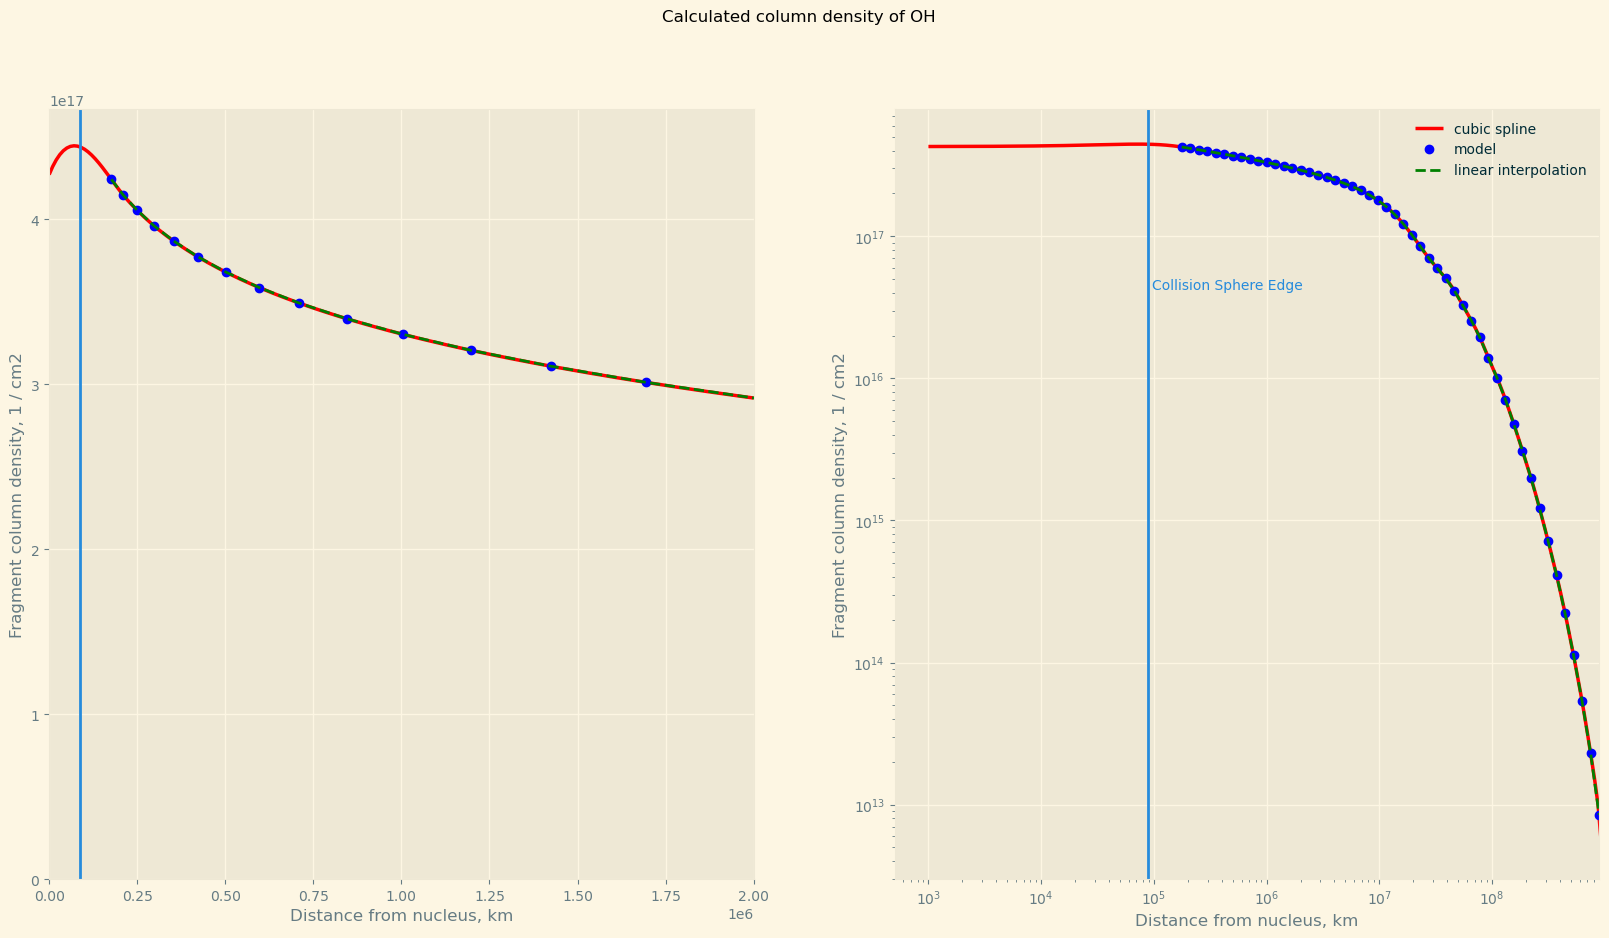

In [16]:
solarbluecol = np.array([38, 139, 220]) / 255.
solarblue = (solarbluecol[0], solarbluecol[1], solarbluecol[2], 1)
solargreencol = np.array([133, 153, 0]) / 255.
solargreen = (solargreencol[0], solargreencol[1], solargreencol[2], 1)
solarblackcol = np.array([0, 43, 54]) / 255.
solarblack = (solarblackcol[0], solarblackcol[1], solarblackcol[2], 1)

def show_column_density_plots(vmr, r_units, cd_units, frag_name):
    """ Show the radial density of the fragment species """

    x_min_logplot = 3
    x_max_logplot = 9

    x_min_linear = (0 * u.km).to(u.m)
    x_max_linear = (2000 * u.km).to(u.m)

    lin_interp_x = np.linspace(x_min_linear.value, x_max_linear.value, num=200)
    lin_interp_y = vmr.column_density_interpolation(lin_interp_x)/(u.m**2)
    lin_interp_x *= u.m

    log_interp_x = np.logspace(x_min_logplot, x_max_logplot, num=200)
    log_interp_y = vmr.column_density_interpolation(log_interp_x)/(u.m**2)
    log_interp_x *= u.m

    plt.style.use('Solarize_Light2')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    ax1.set(xlabel=f'Distance from nucleus, {r_units.to_string()}')
    ax1.set(ylabel=f"Fragment column density, {cd_units.unit.to_string()}")
    ax2.set(xlabel=f'Distance from nucleus, {r_units.to_string()}')
    ax2.set(ylabel=f"Fragment column density, {cd_units.unit.to_string()}")
    fig.suptitle(f"Calculated column density of {frag_name}")

    ax1.set_xlim([x_min_linear, x_max_linear])
    ax1.plot(lin_interp_x, lin_interp_y, color="red",  linewidth=2.5, linestyle="-", label="cubic spline")
    ax1.plot(vmr.column_density_grid, vmr.column_density, 'bo', label="model")
    ax1.plot(vmr.column_density_grid, vmr.column_density, 'g--', label="linear interpolation")

    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.loglog(log_interp_x, log_interp_y, color="red",  linewidth=2.5, linestyle="-", label="cubic spline")
    ax2.loglog(vmr.column_density_grid, vmr.column_density, 'bo', label="model")
    ax2.loglog(vmr.column_density_grid, vmr.column_density, 'g--', label="linear interpolation")

    ax1.set_ylim(bottom=0)

    # Mark the beginning of the collision sphere
    ax1.axvline(x=vmr.collision_sphere_radius, color=solarblue)
    ax2.axvline(x=vmr.collision_sphere_radius, color=solarblue)

    # Only plot as far as the maximum radius of our grid on log-log plot
    ax2.set_xlim(right=vmr.max_grid_radius)

    # Mark the collision sphere
    plt.text(vmr.collision_sphere_radius*1.1, lin_interp_y[0]/10, 'Collision Sphere Edge', color=solarblue)

    legend = plt.legend(loc='upper right', frameon=False)
    for l_text in legend.get_texts():
        l_text.set_color(solarblack)
    plt.show()


# for graphing with astropy units
quantity_support()
show_column_density_plots(vmr, u.km, 1/u.cm**2, 'OH')



### 3D plot of the interpolated column density

/var/folders/1n/8mdnjzr95m3c_nwpkkxth8340000gn/T/ipykernel_34424/414349715.py:30: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_pane_color(solargreen)
/var/folders/1n/8mdnjzr95m3c_nwpkkxth8340000gn/T/ipykernel_34424/414349715.py:31: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_pane_color(solarblue)
/var/folders/1n/8mdnjzr95m3c_nwpkkxth8340000gn/T/ipykernel_34424/414349715.py:32: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.set_pane_color(solarblack)


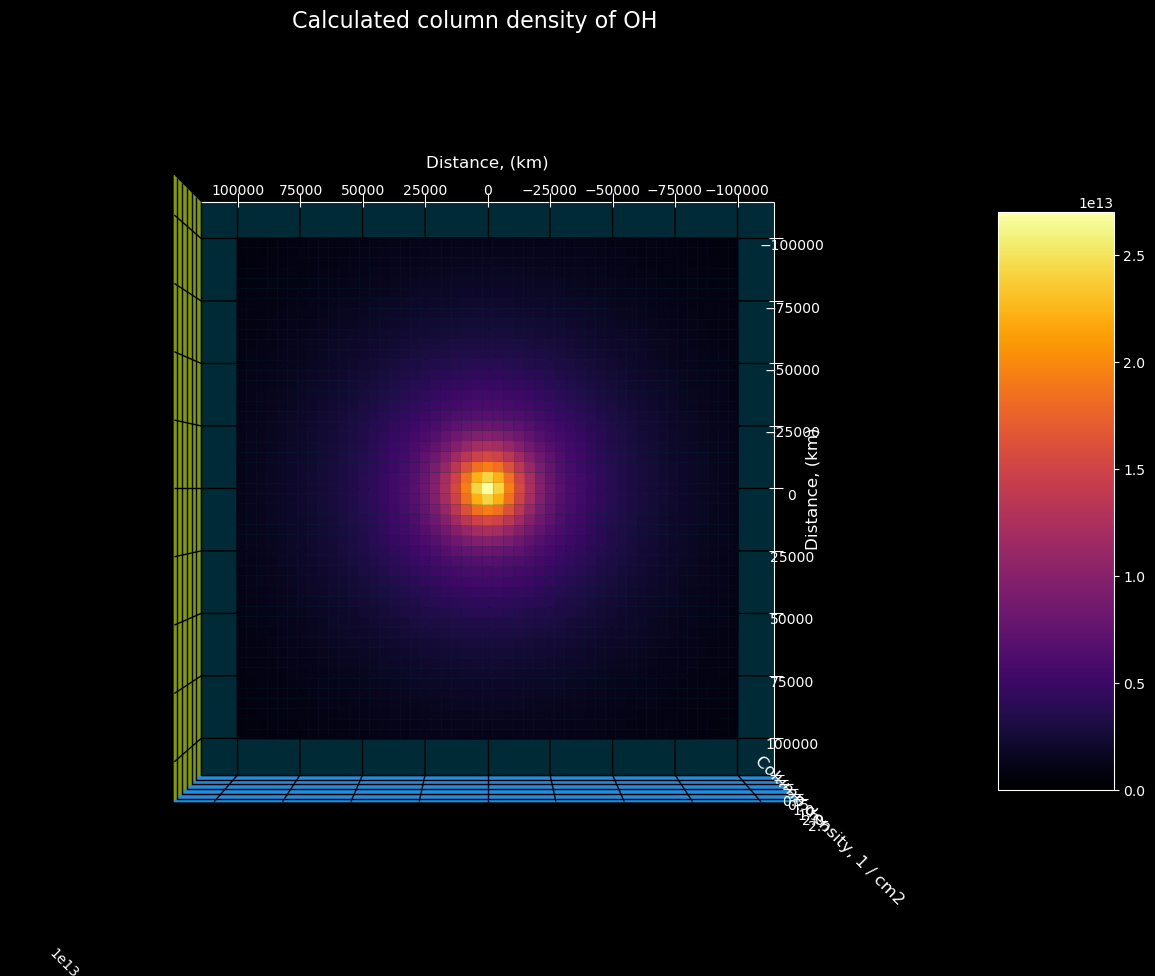

In [23]:
def show_3d_column_density_plot(vmr, x_min, x_max, y_min, y_max, grid_step_x, grid_step_y, r_units, cd_units, frag_name):
    """ 3D plot of column density """

    x = np.linspace(x_min.to(u.m).value, x_max.to(u.m).value, grid_step_x)
    y = np.linspace(y_min.to(u.m).value, y_max.to(u.m).value, grid_step_y)
    xv, yv = np.meshgrid(x, y)
    z = vmr.column_density_interpolation(np.sqrt(xv**2 + yv**2))
    # column_density_interpolation spits out m^-2
    fz = (z/u.m**2).to(cd_units)

    xu = np.linspace(x_min.to(r_units), x_max.to(r_units), grid_step_x)
    yu = np.linspace(y_min.to(r_units), y_max.to(r_units), grid_step_y)
    xvu, yvu = np.meshgrid(xu, yu)

    plt.style.use('Solarize_Light2')
    plt.style.use('dark_background')
    plt.rcParams['grid.color'] = "black"

    fig = plt.figure(figsize=(15, 15))
    ax = plt.axes(projection='3d')
    surf = ax.plot_surface(xvu, yvu, fz, cmap='inferno', vmin=0, edgecolor='none')

    plt.gca().set_zlim(bottom=0)

    ax.set_xlabel(f'Distance, ({r_units.to_string()})')
    ax.set_ylabel(f'Distance, ({r_units.to_string()})')
    ax.set_zlabel(f"Column density, {cd_units.unit.to_string()}")
    plt.title(f"Calculated column density of {frag_name}")

    ax.w_xaxis.set_pane_color(solargreen)
    ax.w_yaxis.set_pane_color(solarblue)
    ax.w_zaxis.set_pane_color(solarblack)

    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.view_init(90, 90)
    plt.show()


show_3d_column_density_plot(vmr, -100000*u.km, 100000*u.km, -100000*u.km, 100000*u.km, 50, 50, u.km, 1/u.cm**2, 'OH')

### Obtaining total counts of fragments within apertures with total_number()
The model's coma object is compatible with any sbpy aperture for obtaining total counts of fragments:

In [24]:
max_r = vmr.max_grid_radius.to_value(u.m)
print("Number of fragments in")
# Set rectangular aperture to be the size of the entire grid
ap1 = sba.RectangularAperture((max_r, 
                               max_r) * u.m )
print("\tLarge rectangular aperture: ", coma_sine.total_number(ap1))

# One more time with a circular aperture
ap2 = sba.CircularAperture((max_r) * u.m)
print("\tLarge circular aperture: ", coma_sine.total_number(ap2))

Number of fragments in
	Large rectangular aperture:  1.9513579963113747e+33
	Large circular aperture:  2.023818343905977e+33


The model's data is stored as a function of radial distance from the nucleus, so the circular aperture is generally more trustworthy with its results.

### Optional parameters to the model

Beyond the production and time dependence, the following can be passed to VectorialModel to tweak its behavior:

radial_points (int): Number of grid points to use for the radial density grids, both volume and column density

radial_substeps (int): Controls how much each grid point will slice up the density-contributing sections of the outflowing column of parents

angular_points (int): Number of angular slices to take of the space around the nucleus

parent_destruction_level (float): Percentage of parent molecules that will be destroyed before the grid gets cut off

fragment_destruction_level (float): Similar, but for fragments

max_fragment_lifetimes (float): If a fragment has to travel farther than this many lifetimes to contribute to the density at another point in the coma, we ignore it entirely

print_progess (bool): This will periodically print out progress while calculating fragment density